# Simulated annealing for TSP

Warning: adjust the file path according to your OS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.stats import sem, t
import pandas as pd
import seaborn as sns

In [3]:
def get_city_coord_dict(filename):
    '''Opens the file with cities and corresponding coordinates. Puts it in an ordered dictionary.
    Input: file name with path.
    Ouput: Ordered dictionary of cities with corresponding x and y coordinates in a numpy array.'''
    city_coord_dict = {}

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line[0].isdigit():
                split = line.split()

                city_coord_dict[int(split[0])] = np.array([int(coord) for coord in line.split()[-2:]])

    return OrderedDict(city_coord_dict)

#Open initial file, store cities with coordinates
filename = "TSP-Configurations/eil51.tsp.txt"
init_cities = get_city_coord_dict(filename)

def get_distance(city_a, city_b):
    '''Calculates distance between city a and city b.
    Input: numpy arrays of city_a and city_b coordinates.
    Output: Euclidean distance between the two cities (as a scalar)'''
    return np.linalg.norm(city_a - city_b)

def total_distance(cities):
    '''Calculates the total distance of the route of visiting all cities in order specified.
    Input: OrderedDict of cities (keys) with their coordinates (np.arrays of x and y)
    Output: Total route distance (scalar)'''

    city_coords = list(cities.values())

    #Init variable: link last city with first
    total_distance = get_distance(city_coords[-1], city_coords[0])
    
    #Connect every subsequent pair of cities
    for i in range(len(cities) -1):
        total_distance += get_distance(city_coords[i], city_coords[i+1])

    return total_distance

def visualize_routes(cities):
    '''Visualize the cities on a plane and the routes between cities.
    Input: OrderedDict of cities (keys) and coordinates(values).
    Output: plot of cities and routes between them.
    '''
    city_coords = list(cities.values())
    for city in city_coords:
        plt.scatter(city[0], city[1])

    #Add connecting lines 
    for i in range(len(city_coords) - 1):
        plt.plot([city_coords[i][0], city_coords[i+1][0]], [city_coords[i][1], city_coords[i+1][1]])

    #Connect last city to first
    plt.plot([city_coords[-1][0], city_coords[0][0]], [city_coords[-1][1], city_coords[0][1]])
    plt.show()


# Initial city arrangement

Route distance of initial solutionis : 1313.4683444443463


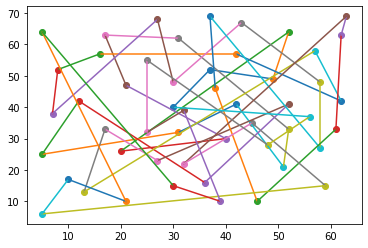

In [4]:
#Get distance of the initial arrangement of cities
init_distance = total_distance(init_cities)
print(f'Route distance of initial solutionis : {init_distance}')
#Visualize initial route arrangement
visualize_routes(init_cities)

In [5]:
class SimulatedAnnealing:
    def __init__(self, cities, C, T0, max_step = 100, init_seed = 1):
        self.cities_old = cities
        self.C = C
        self.T0 = T0
        self.step = 0
        self.max_step = max_step
        self.seed = init_seed

    def proposal(self):
        # Select a random key from the dictionary
        random_key = np.random.choice(list(self.cities_old.keys()))
        value = self.cities_old[random_key]

        proposal_cities = self.cities_old.copy()
        del proposal_cities[random_key]

        #Move it to here     
        new_index = np.random.randint(0, len(self.cities_old) - 1)

        # Create a new dictionary with the rearranged order
        proposal_cities = OrderedDict(list(self.cities_old.items())[:new_index] + [(random_key, value)] + list(self.cities_old.items())[new_index:])
        return proposal_cities

    
    def evaluate(self, cities, proposal_cities, T):
        alpha_func =  min(np.exp(-(total_distance(proposal_cities) - total_distance(cities))/T), 1)
        return alpha_func
    

    def select(self, alpha_func, proposal_cities):
        u = np.random.uniform()
        if u <= alpha_func:
            #accept
            cities_new = proposal_cities
        else:
            #reject
            cities_new = self.cities_old

        return cities_new
    

    def run(self):
        while self.step < self.max_step:
            self.seed += 1
            # The temperature scheme (the cooling scheme)
            T = (self.C*np.log(self.step+self.T0))**(-1)
            self.step = self.step + 1
            # 1. Proposal
            proposal_cities = self.proposal()
            # 2. Evaluate
            alpha_func = self.evaluate(self.cities_old, proposal_cities, T)
            # 3. Select
            cities_new = self.select(alpha_func, proposal_cities)
            self.cities_old = cities_new

        return cities_new

# Attempted solution

In [8]:
#Run the simulator
if __name__== '__main__':
    sim_annealing = SimulatedAnnealing(cities = init_cities, C = 0.1, T0 = 0.1, max_step = 200000)
    cities_new = sim_annealing.run()

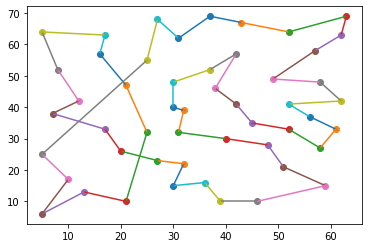

Total distance of simulated annealing solution is: 481.85078973610985
Order of the cities is as follows: odict_keys([31, 28, 3, 36, 35, 20, 2, 29, 21, 16, 50, 34, 30, 9, 38, 11, 32, 22, 1, 27, 51, 46, 12, 5, 49, 10, 39, 33, 45, 15, 44, 37, 17, 4, 18, 25, 14, 24, 43, 7, 23, 6, 47, 42, 19, 40, 41, 13, 48, 26, 8])


In [9]:
visualize_routes(cities_new)
print(f'Total distance of simulated annealing solution is: {total_distance(cities_new)}')
print(f'Order of the cities is as follows: {cities_new.keys()}')

# Compare with optimal solution

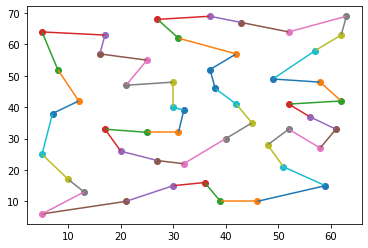

Total distance of optimal route is: 429.983311983384
Optimal order of the cities is as follows: odict_keys([1, 22, 8, 26, 31, 28, 3, 36, 35, 20, 2, 29, 21, 16, 50, 34, 30, 9, 49, 10, 39, 33, 45, 15, 44, 42, 40, 19, 41, 13, 25, 14, 24, 43, 7, 23, 48, 6, 27, 51, 46, 12, 47, 18, 4, 17, 37, 5, 38, 11, 32])


In [10]:
def get_optimal_sol(filename, cities_dict):
    '''Opens the file with cities ordered for an optimal path. Sorted input dictionary accordingly.
    Input: file name with path, city/coordinate dictionary to be sorted
    Ouput: Optimally sorted ordered dictionary of cities with corresponding x and y coordinates (numpy array)'''
    city_order = []

    with open(filename, 'r') as file:
        tour_section_started = False

        for line in file:
            line = line.strip()

            if tour_section_started and line[0].isdigit():
                city_order.append(int(line))
            elif line.startswith("TOUR_SECTION"):
                tour_section_started = True
            elif line.startswith("-1"):
                break
        
    opt_sol_dict = OrderedDict((key, cities_dict[key]) for key in city_order)
        
    return opt_sol_dict


#Compare with optimal solution
filename = "TSP-Configurations/eil51.opt.tour.txt"
opt_sol_dict = get_optimal_sol(filename, init_cities)
visualize_routes(opt_sol_dict)
print(f'Total distance of optimal route is: {total_distance(opt_sol_dict)}')
print(f'Optimal order of the cities is as follows: {opt_sol_dict.keys()}')

# Investigate changes in T$_{0}$, for constant C = 1 and Max_step = 500

/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_72641/2856506632.py:47: RuntimeWarning: divide by zero encountered in scalar power
  T = (self.C*np.log(self.step+self.T0))**(-1)


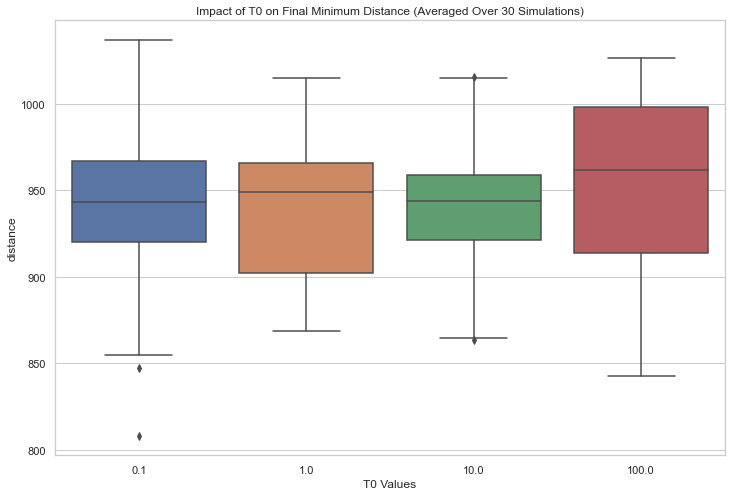

In [63]:
# Set the values of T0 for the experiment
T0_values = [0.1, 1, 10, 100]

# Initialize an empty DataFrame to store results
df_results = pd.DataFrame(columns=['simulation', 'cooling_schedule', 'mc_length', 't0', 'distance'])

# Run the experiment for each value of T0 and for 10 simulations
num_simulations = 30
for t0_value in T0_values:
    for simulation_index in range(num_simulations):
        # Run the simulated annealing algorithm with a unique seed for each simulation
        sa_instance = SimulatedAnnealing(init_cities, C=1, T0=t0_value, max_step=500, init_seed=simulation_index + 1)
        final_cities = sa_instance.run()

        # Record the results in the DataFrame
        df_results = pd.concat([df_results, pd.DataFrame({
            'simulation': [f'SA-{simulation_index + 1}'],
            'cooling_schedule': ['Logarithmic'],
            'mc_length': [500],
            't0': [t0_value],
            'distance': [total_distance(final_cities)]
        })], ignore_index=True)

# Convert 't0' to categorical
df_results['t0'] = pd.Categorical(df_results['t0'])

# Create a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='t0', y='distance', data=df_results)
plt.title('Impact of T0 on Final Minimum Distance (Averaged Over 30 Simulations)')
plt.xlabel('T0 Values')
plt.show()

# Investigate changes in C, for constant T$_{0}$ = 10 and Max_step = 500

/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_72641/2856506632.py:27: RuntimeWarning: overflow encountered in exp
  alpha_func =  min(np.exp(-(total_distance(proposal_cities) - total_distance(cities))/T), 1)


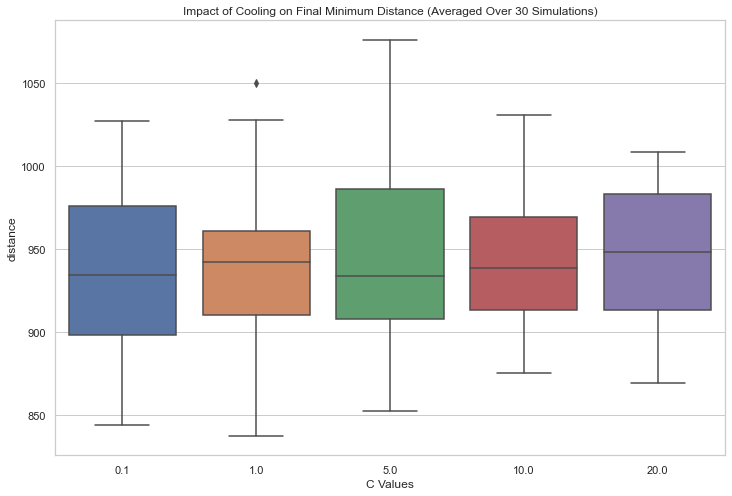

In [67]:
# Set the values of T0 for the experiment
C_values = [0.1, 1, 5, 10, 20]

# Initialize an empty DataFrame to store results
df_results = pd.DataFrame(columns=['simulation', 'cooling_schedule', 'mc_length', 'C_values', 'distance'])

# Run the experiment for each value of T0 and for 10 simulations
num_simulations = 30
for c_value in C_values:
    for simulation_index in range(num_simulations):
        # Run the simulated annealing algorithm with a unique seed for each simulation
        sa_instance = SimulatedAnnealing(init_cities, C=c_value, T0=10, max_step=500, init_seed=simulation_index + 1)
        final_cities = sa_instance.run()

        # Record the results in the DataFrame
        df_results = pd.concat([df_results, pd.DataFrame({
            'simulation': [f'SA-{simulation_index + 1}'],
            'cooling_schedule': ['Logarithmic'],
            'mc_length': [500],
            'c_value': [c_value],
            'distance': [total_distance(final_cities)]
        })], ignore_index=True)

df_results['c_value'] = pd.Categorical(df_results['c_value'])

# Create a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='c_value', y='distance', data=df_results)
plt.title('Impact of Cooling on Final Minimum Distance (Averaged Over 30 Simulations)')
plt.xlabel('C Values')
plt.show()

# Change in Max steps

/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_72641/2856506632.py:47: RuntimeWarning: divide by zero encountered in scalar power
  T = (self.C*np.log(self.step+self.T0))**(-1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_72641/2854774575.py:25: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_results['t0'] = pd.Categorical(df_results['t0'])


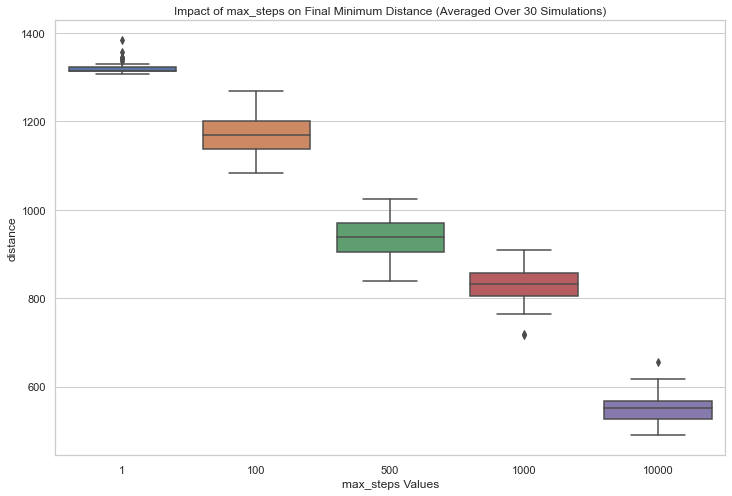

In [68]:
# Set the values of max_steps for the experiment
max_step_values = [1, 100, 500, 1000, 10000]

# Initialize an empty DataFrame to store results
df_results = pd.DataFrame(columns=['simulation', 'cooling_schedule', 'mc_length', 't0', 'distance'])

# Run the experiment for each value of max_steps and for 10 simulations
num_simulations = 30
for max_step_value in max_step_values:
    for simulation_index in range(num_simulations):
        # Run the simulated annealing algorithm with a unique seed for each simulation
        sa_instance = SimulatedAnnealing(init_cities, C=1, T0=1, max_step=max_step_value, init_seed=simulation_index + 1)
        final_cities = sa_instance.run()

        # Record the results in the DataFrame
        df_results = pd.concat([df_results, pd.DataFrame({
            'simulation': [f'SA-{simulation_index + 1}'],
            'cooling_schedule': ['Logarithmic'],
            'mc_length': [max_step_value],
            't0': [1],
            'distance': [total_distance(final_cities)]
        })], ignore_index=True)

df_results['t0'] = pd.Categorical(df_results['t0'])

# Create a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='mc_length', y='distance', data=df_results)
plt.title('Impact of max_steps on Final Minimum Distance (Averaged Over 30 Simulations)')
plt.xlabel('max_steps Values')
plt.show()

# Implement different Cooling schedules

In [10]:
class SimulatedAnnealing:
    def __init__(self, cities, C, T0, max_step = 100, init_seed = 1):
        self.cities_old = cities
        self.C = C
        self.T0 = T0
        self.step = 0
        self.max_step = max_step
        self.seed = init_seed

    def proposal(self):
        # Select a random key from the dictionary
        random_key = np.random.choice(list(self.cities_old.keys()))
        value = self.cities_old[random_key]

        proposal_cities = self.cities_old.copy()
        del proposal_cities[random_key]

        #Move it to here     
        new_index = np.random.randint(0, len(self.cities_old) - 1)

        # Create a new dictionary with the rearranged order
        proposal_cities = OrderedDict(list(self.cities_old.items())[:new_index] + [(random_key, value)] + list(self.cities_old.items())[new_index:])
        return proposal_cities

    
    def evaluate(self, cities, proposal_cities, T):
        alpha_func =  min(np.exp(-(total_distance(proposal_cities) - total_distance(cities))/T), 1)
        return alpha_func
    

    def select(self, alpha_func, proposal_cities):
        u = np.random.uniform()
        if u <= alpha_func:
            #accept
            cities_new = proposal_cities
        else:
            #reject
            cities_new = self.cities_old

        return cities_new

    def exponential_cooling(self, step):
        # Exponential cooling scheme
        return self.T0 * np.exp(-self.C * step)

    def linear_cooling(self, step):
        # Linear cooling scheme
        return self.T0 / (1 + self.C * step)

#     def run(self, cooling_schedule):
#         while self.step < self.max_step:
#             self.seed += 1
#             # The temperature scheme (the cooling scheme)
#             if cooling_schedule == 'logarithmic':
#                 T = (self.C * np.log(self.step + self.T0))**(-1)
#             elif cooling_schedule == 'exponential':
#                 T = self.exponential_cooling(self.step)
#             elif cooling_schedule == 'linear':
#                 T = self.linear_cooling(self.step)
#             else:
#                 raise ValueError("Invalid cooling_schedule. Choose from 'logarithmic', 'exponential', or 'linear'.")

#             self.step = self.step + 1
#             # 1. Proposal
#             proposal_cities = self.proposal()
#             # 2. Evaluate
#             alpha_func = self.evaluate(self.cities_old, proposal_cities, T)
#             # 3. Select
#             cities_new = self.select(alpha_func, proposal_cities)
#             self.cities_old = cities_new

#         return cities_new


    def run(self, cooling_scheme):
        while self.step < self.max_step:
            self.seed += 1
            # The temperature scheme (the cooling scheme)
            if cooling_scheme == 'logarithmic':
                T = (self.C * np.log(self.step + self.T0))**(-1)
            elif cooling_scheme == 'exponential':
                T = self.exponential_cooling(self.step)
            elif cooling_scheme == 'linear':
                T = self.linear_cooling(self.step)
            else:
                raise ValueError("Invalid cooling_scheme. Choose from 'logarithmic', 'exponential', or 'linear'.")

            self.step = self.step + 1
            # 1. Proposal
            proposal_cities = self.proposal()
            # 2. Evaluate
            alpha_func = self.evaluate(self.cities_old, proposal_cities, T)
            # 3. Select
            cities_new = self.select(alpha_func, proposal_cities)
            self.cities_old = cities_new

        return cities_new


/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_72641/204418052.py:56: RuntimeWarning: divide by zero encountered in scalar power
  T = (self.C * np.log(self.step + self.T0))**(-1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_72641/204418052.py:27: RuntimeWarning: overflow encountered in exp
  alpha_func =  min(np.exp(-(total_distance(proposal_cities) - total_distance(cities))/T), 1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_72641/204418052.py:27: RuntimeWarning: overflow encountered in scalar divide
  alpha_func =  min(np.exp(-(total_distance(proposal_cities) - total_distance(cities))/T), 1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_72641/204418052.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  alpha_func =  min(np.exp(-(total_distance(proposal_cities) - total_distance(cities))/T), 1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_72641/204418052.py:27: RuntimeWarning: invalid value encountere

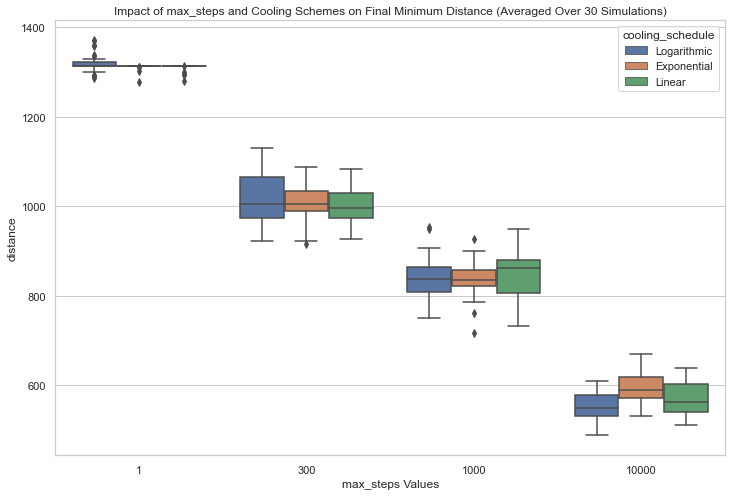

In [70]:
# Set the values of max_steps for the experiment
max_step_values = [1, 300, 1000, 10000]

# Initialize an empty DataFrame to store results
df_results = pd.DataFrame(columns=['simulation', 'cooling_schedule', 'mc_length', 't0', 'distance'])

# Run the experiment for each value of max_steps, each cooling schedule, and for 10 simulations
num_simulations = 30
cooling_schemes = ['logarithmic', 'exponential', 'linear']

for cooling_schedule in cooling_schemes:
    for max_step_value in max_step_values:
        for simulation_index in range(num_simulations):
            # Run the simulated annealing algorithm with a unique seed for each simulation
            sa_instance = SimulatedAnnealing(init_cities, C=1, T0=1, max_step=max_step_value, init_seed=simulation_index + 1)
            final_cities = sa_instance.run(cooling_schedule)

            # Record the results in the DataFrame
            df_results = pd.concat([df_results, pd.DataFrame({
                'simulation': [f'SA-{simulation_index + 1}'],
                'cooling_schedule': [cooling_schedule.capitalize()],
                'mc_length': [max_step_value],
                't0': [1],
                'distance': [total_distance(final_cities)]
            })], ignore_index=True)

# Convert 't0' to categorical
df_results['t0'] = pd.Categorical(df_results['t0'])

# Create a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='mc_length', y='distance', hue='cooling_schedule', data=df_results)
plt.title('Impact of max_steps and Cooling Schemes on Final Minimum Distance (Averaged Over 30 Simulations)')
plt.xlabel('max_steps Values')
plt.show()

/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_75265/421040573.py:80: RuntimeWarning: divide by zero encountered in scalar power
  T = (self.C * np.log(self.step + self.T0))**(-1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_75265/421040573.py:27: RuntimeWarning: overflow encountered in exp
  alpha_func =  min(np.exp(-(total_distance(proposal_cities) - total_distance(cities))/T), 1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_75265/421040573.py:27: RuntimeWarning: overflow encountered in scalar divide
  alpha_func =  min(np.exp(-(total_distance(proposal_cities) - total_distance(cities))/T), 1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_75265/421040573.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  alpha_func =  min(np.exp(-(total_distance(proposal_cities) - total_distance(cities))/T), 1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_75265/421040573.py:27: RuntimeWarning: invalid value encountere

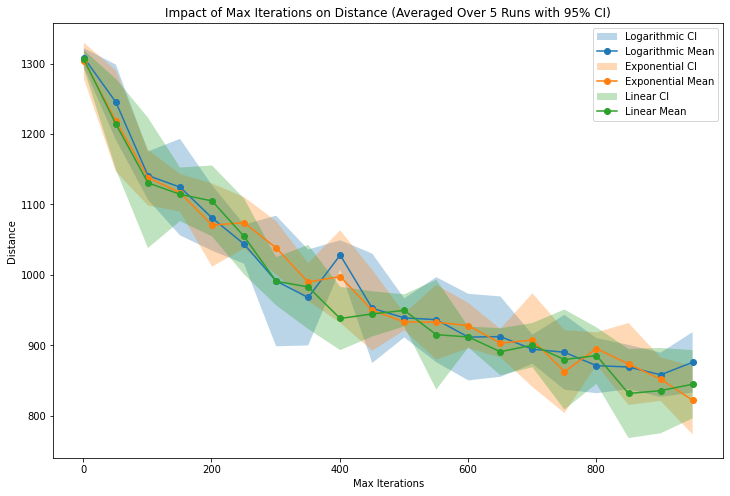

In [12]:
def calculate_confidence_interval(data, confidence=0.95):
    """
    Calculate the confidence interval for the given data.

    Parameters:
    - data: List or array-like data.
    - confidence: Confidence level (default is 0.95).

    Returns:
    - Tuple containing the lower and upper bounds of the confidence interval.
    """
    n = len(data)
    m = np.mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return m - h, m + h

def run_experiment(cooling_scheme, max_iterations_range, num_runs=5):
    results = {'Iteration': [], 'Distance': []}

    for max_iter in max_iterations_range:
        distances = []

        for _ in range(num_runs):
            sa_instance = SimulatedAnnealing(init_cities, C=1, T0=1, max_step=max_iter, init_seed=np.random.randint(1, 1000))
            final_cities = sa_instance.run(cooling_scheme)

            distances.append(total_distance(final_cities))

        mean_distance = np.mean(distances)
        lower_bound, upper_bound = calculate_confidence_interval(distances)

        results['Iteration'].append(max_iter)
        results['Distance'].append((mean_distance, lower_bound, upper_bound))

    return pd.DataFrame(results)

# Run experiment for each cooling scheme
cooling_schemes = ['logarithmic', 'exponential', 'linear']
max_iterations_range = np.arange(1, 1001, 50)  # Adjust the range as needed

plt.figure(figsize=(12, 8))

for scheme in cooling_schemes:
    df_results = run_experiment(scheme, max_iterations_range)
    plt.fill_between(df_results['Iteration'], df_results['Distance'].apply(lambda x: x[1]), df_results['Distance'].apply(lambda x: x[2]), alpha=0.3, label=f'{scheme.capitalize()} CI')
    plt.plot(df_results['Iteration'], df_results['Distance'].apply(lambda x: x[0]), label=f'{scheme.capitalize()} Mean', marker='o')

plt.title('Impact of Max Iterations on Distance (Averaged Over 5 Runs with 95% CI)')
plt.xlabel('Max Iterations')
plt.ylabel('Distance')
plt.legend()
plt.show()